In [37]:
from numpy import array, dstack, roll
from math import ceil, sqrt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.transform import rescale
from time import time
from skimage.io import imread
from IPython.display import Image
from IPython.core.display import HTML 
from sklearn.metrics import mean_squared_error

In [38]:
def crop(image, percent):
    height, width = image.shape[0], image.shape[1]
    cutted_h = int(height * percent / 100)
    cutted_w = int(width * percent / 100)
    return image[cutted_h:height - cutted_h, cutted_w:width - cutted_w]

In [39]:
def cross_corellation(first_image, second_image):
    return np.sum(first_image * second_image) / sqrt(np.sum(first_image ** 2) * np.sum(second_image ** 2))

In [40]:
def mean_squared_err(first_image, second_image):
    return np.sum((first_image - second_image) ** 2)

In [79]:
def find_offset_one_dim(first_color, second_color, error_func, xrange, yrange, percent=6):
    #first_color, second_color = crop(first_color, percent), crop(second_color, percent)
    min_error = error_func(first_color, second_color)
    x_min = 0
    y_min = 0
    for x in xrange:
        for y in yrange:
            temp_first = np.roll(first_color, x, axis=0)
            temp_first = np.roll(temp_first, y, axis=1)
            temp_second = second_color
            new_error = error_func(temp_first, temp_second)
            if (new_error < min_error):
                min_error = new_error
                x_min = x
                y_min = y
    return (x_min, y_min)

In [108]:
def find_offset_cut(stable_color, move_color, error_func, xrange, yrange, percent=6):
    #first_color, second_color = crop(first_color, percent), crop(second_color, percent)
    height, width = stable_color.shape
    min_error = error_func(stable_color, move_color)
    x_min = 0
    y_min = 0
    for x in xrange:
        for y in yrange:
            if (x >= 0 and y >= 0):
                # уходит в 4 четверть
                x = abs(x)
                y = abs(y)
                temp_stable = stable_color[x:height, y:width]
                temp_move = move_color[:height - x, :width - y]
                new_error = error_func(temp_move, temp_stable)
                if (new_error < min_error):
                    min_error = new_error
                    x_min = x
                    y_min = y
            
            elif (x > 0 and y < 0):
                # уходит в 3 четверть
                x = abs(x)
                y = abs(y)
                temp_stable = stable_color[x:height, :width - y]
                temp_move = move_color[:height - x, y:width]
                new_error = error_func(temp_move, temp_stable)
                if (new_error < min_error):
                    min_error = new_error
                    x_min = x
                    y_min = -y
            
            elif (x <= 0 and y <= 0):
                # уходить во 2 четверть
                x = abs(x)
                y = abs(y)
                temp_stable = stable_color[:height - x, :width - y]
                temp_move = move_color[x:height, y:width]
                new_error = error_func(temp_move, temp_stable)
                if (new_error < min_error):
                    min_error = new_error
                    x_min = -x
                    y_min = -y
                
            else:
                #уходит в 1 четверть
                temp_stable = stable_color[:height - x, y:width]
                temp_move = move_color[x:height, :width - y]
                new_error = error_func(temp_move, temp_stable)
                if (new_error < min_error):
                    min_error = new_error
                    x_min = -x
                    y_min = y
    return (x_min, y_min)

In [109]:
def find_offset_one_dim_cr(first_color, second_color, error_func, xrange, yrange, percent):
    first_color, second_color = crop(first_color, percent), crop(second_color, percent)
    min_error = error_func(first_color, second_color)
    x_min = 0
    y_min = 0
    for x in xrange:
        for y in yrange:
            temp_first = np.roll(first_color, x, axis=0)
            temp_first = np.roll(temp_first, y, axis=1)
            temp_second = second_color
            new_error = error_func(temp_first, temp_second)
            if (new_error > min_error):
#                print('NEW', new_error)
                min_error = new_error
                x_min = x
                y_min = y
    return (x_min, y_min)

(639, 246)
0 0
3 1


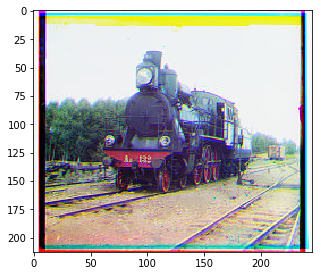

In [110]:
image = imread('small.jpg')
image = np.intc(image)
image = image[:image.shape[0] // 3 * 3, :image.shape[1] // 3 * 3]
print(image.shape)
b, g, r = np.split(image, 3)

dif = 15
percent = 5
dx_blue, dy_blue = find_offset_cut(g, b, mean_squared_error, np.arange(-dif, dif + 1), np.arange(-dif, dif + 1), percent)
dx_red, dy_red = find_offset_cut(g, r, mean_squared_error, np.arange(-dif, dif + 1), np.arange(-dif, dif + 1), percent)

print(dx_blue, dy_blue)
print(dx_red, dy_red)

b = np.roll(b, dx_blue, axis=0) #были с минусами ВСЕ 4
b = np.roll(b, dy_blue, axis=1)

r = np.roll(r, dx_red, axis=0)
r = np.roll(r, dy_red, axis=1)

rgb_image = np.dstack([r, g, b])

plt.figure(figsize=(5, 5))
plt.imshow(rgb_image)


In [111]:
def find_offset(first_img, second_img):
    if (first_img.shape[0] < 500 or first_img.shape[1] < 500):
        diff_x, diff_y = find_offset_one_dim(first_img, second_img, 
                                   mean_squared_error, 
                                   np.arange(-15, 16), 
                                   np.arange(-15, 16))
        return diff_x, diff_y


    temp_first = rescale(first_img, .5, mode='constant')
    temp_second = rescale(second_img, .5, mode='constant')
    
    diff_x, diff_y = find_offset(temp_first, temp_second)
    diff_x *= 2
    diff_y *= 2
    return find_offset_one_dim(first_img, second_img, 
                               mean_squared_error, 
                               np.arange(diff_x - 1, diff_x + 2), 
                               np.arange(diff_y - 1, diff_y + 2))

In [69]:
big = imread('small.jpg')
#plt.figure(figsize=(24, 8))
#plt.imshow(big, cmap='gray')
big = np.intc(big)
print(big.shape)


b, g, r = np.split(big[:big.shape[0] // 3 * 3], 3)
dx_blue, dy_blue = find_offset(g, b)
dx_red, dy_red = find_offset(g, r)

(640, 246)


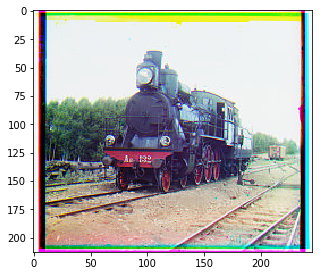

In [70]:
big = big[:big.shape[0] // 3 * 3, :big.shape[1] // 3 * 3]
b, g, r = np.split(big, 3)

b = np.roll(b, -dx_blue, axis=0)
b = np.roll(b, -dy_blue, axis=1)

r = np.roll(r, -dx_red, axis=0)
r = np.roll(r, -dy_red, axis=1)

rgb_image = np.dstack([r, g, b])
plt.figure(figsize=(5, 5))
plt.imshow(rgb_image)

In [46]:
print(386 + dx_blue - big.shape[0] // 3)
print(386 + dx_red + big.shape[0] // 3)
print(big.shape[0] // 3)

176
596
213
